<center><h1> Predict heart failure with Watson Machine Learning</h1></center>
![alt text](https://www.cdc.gov/dhdsp/images/heart_failure.jpg "Heart failure")
<p>This notebook contains steps and code to create a predictive model to predict heart failure and then deploy that model to Watson Machine Learning so it can be used in an application.</p>
## Learning Goals
The learning goals of this notebook are:
* Load a CSV file into the  Object Storage Service linked to your Data Science Experience 
* Create an Apache® Spark machine learning model
* Train and evaluate a model
* Persist a model in a Watson Machine Learning repository

## 1. Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:
* Create a Watson Machine Learning Service instance (a free plan is offered) and associate it with your project
* Upload heart failure  data to the Object Store service that is part of your data Science Experience trial


## 2. Load and explore data
<p>In this section you will load the data as an Apache® Spark DataFrame and perform a basic exploration.</p>

<p>Load the data to the Spark DataFrame from your associated Object Storage instance.</p>

In [3]:
# IMPORTANT Follow the lab instructions to insert Spark Session Data Frame to get access to the data used in this notebook
# Ensure the Spark Session Data Frame is named df_data
# Add the .option('inferSchema','True')\ line after the option line from the inserted code.


#  .option('inferSchema','True')\

import pandas as pd
from pyspark.sql import SQLContext
from pyspark import SparkContext

#sc = SparkContext()
sqlContext = SQLContext(sc)

df_data_pd = pd.read_csv('https://raw.githubusercontent.com/krondor/prime-ml/master/data/patientdataV6.csv')
df_data = sqlContext.createDataFrame(df_data_pd)

In [32]:


import os
from pyspark.sql import SQLContext
# Add asset from file system
df_data = SQLContext(sc).read.csv(os.environ['DSX_PROJECT_DIR']+'/datasets/patientdataV6.csv', header='true', inferSchema = 'true')
df_data.show(5)





+-------------------+------------------+-----------+---+------------+---+---+-------------+--------------+------------------+
|AVGHEARTBEATSPERMIN|PALPITATIONSPERDAY|CHOLESTEROL|BMI|HEARTFAILURE|AGE|SEX|FAMILYHISTORY|SMOKERLAST5YRS|EXERCISEMINPERWEEK|
+-------------------+------------------+-----------+---+------------+---+---+-------------+--------------+------------------+
|                 93|                22|        163| 25|           N| 49|  F|            N|             N|               110|
|                108|                22|        181| 24|           N| 32|  F|            N|             N|               192|
|                 86|                 0|        239| 20|           N| 60|  F|            N|             N|               121|
|                 80|                36|        164| 31|           Y| 45|  F|            Y|             N|               141|
|                 66|                36|        185| 23|           N| 39|  F|            N|             N|            

Explore the loaded data by using the following Apache® Spark DataFrame methods:
* print schema
* print top ten records
* count all records

In [4]:
df_data.printSchema()

root
 |-- AVGHEARTBEATSPERMIN: long (nullable = true)
 |-- PALPITATIONSPERDAY: long (nullable = true)
 |-- CHOLESTEROL: long (nullable = true)
 |-- BMI: long (nullable = true)
 |-- HEARTFAILURE: string (nullable = true)
 |-- AGE: long (nullable = true)
 |-- SEX: string (nullable = true)
 |-- FAMILYHISTORY: string (nullable = true)
 |-- SMOKERLAST5YRS: string (nullable = true)
 |-- EXERCISEMINPERWEEK: long (nullable = true)



As you can see, the data contains ten  fields. The  HEARTFAILURE field is the one we would like to predict (label).

In [5]:
df_data.show()

+-------------------+------------------+-----------+---+------------+---+---+-------------+--------------+------------------+
|AVGHEARTBEATSPERMIN|PALPITATIONSPERDAY|CHOLESTEROL|BMI|HEARTFAILURE|AGE|SEX|FAMILYHISTORY|SMOKERLAST5YRS|EXERCISEMINPERWEEK|
+-------------------+------------------+-----------+---+------------+---+---+-------------+--------------+------------------+
|                 93|                22|        163| 25|           N| 49|  F|            N|             N|               110|
|                108|                22|        181| 24|           N| 32|  F|            N|             N|               192|
|                 86|                 0|        239| 20|           N| 60|  F|            N|             N|               121|
|                 80|                36|        164| 31|           Y| 45|  F|            Y|             N|               141|
|                 66|                36|        185| 23|           N| 39|  F|            N|             N|            

In [6]:
df_data.describe().show()

+-------+-------------------+------------------+------------------+------------------+------------------+------------------+
|summary|AVGHEARTBEATSPERMIN|PALPITATIONSPERDAY|       CHOLESTEROL|               BMI|               AGE|EXERCISEMINPERWEEK|
+-------+-------------------+------------------+------------------+------------------+------------------+------------------+
|  count|              10800|             10800|             10800|             10800|             10800|             10800|
|   mean|  87.11509259259259|20.423148148148147|195.08027777777778| 26.35972222222222|49.965185185185184|119.72953703703703|
| stddev| 19.744375148984492| 12.16532035162301|26.136731865042268|3.8201472810942083|13.079280962015604| 71.14706006382842|
|    min|                 48|                 0|               150|                20|                28|                 0|
|    max|                161|                45|               245|                34|                72|               250|


In [7]:
df_data.count()

10800

As you can see, the data set contains 10800 records.

## 3 Interactive Visualizations w/PixieDust

In [8]:
# To confirm you have the latest version of PixieDust on your system, run this cell
!pip install --user pixiedust==1.1.2

    100% |████████████████████████████████| 153kB 963kB/s ta 0:00:01
  Running setup.py bdist_wheel for pixiedust ... - \ | / - \ done
  Stored in directory: /user-home/1003/.cache/pip/wheels/37/e4/e7/7d45c1323f62f317f2a02d3c9c2c2a74ac3953993a75b05866
Successfully built pixiedust
mxnet 1.1.0 has requirement numpy<=1.13.3, but you'll have numpy 1.14.1 which is incompatible.
  The script jupyter-pixiedust is installed in '/user-home/1003/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


If indicated by the installer, restart the kernel and rerun the notebook until here and continue with the workshop.

In [9]:
import pixiedust

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table SPARK_PACKAGES created successfully
Table USER_PREFERENCES created successfully
Table service_connections created successfully


### Simple visualization using bar charts
With PixieDust display(), you can visually explore the loaded data using built-in charts, such as, bar charts, line charts, scatter plots, or maps.
To explore a data set: choose the desired chart type from the drop down, configure chart options, configure display options.


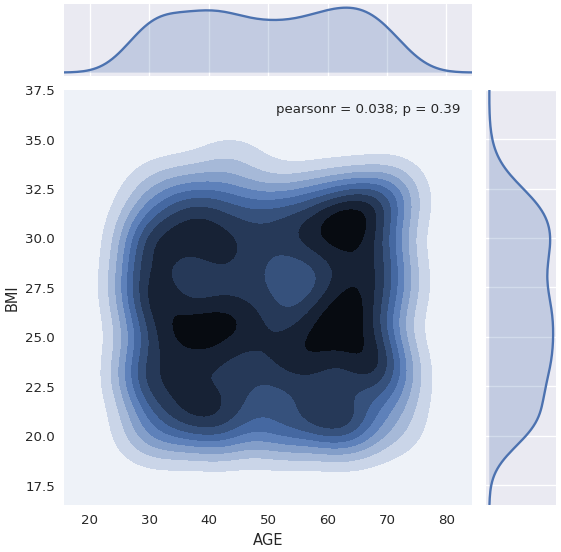

In [10]:
display(df_data)

## 4. Create an Apache® Spark machine learning model
In this section you will learn how to prepare data, create and train an Apache® Spark machine learning model.

### 4.1: Prepare data
In this subsection you will split your data into: train and  test  data sets.

In [11]:
split_data = df_data.randomSplit([0.8, 0.20], 24)
train_data = split_data[0]
test_data = split_data[1]


print "Number of training records: " + str(train_data.count())
print "Number of testing records : " + str(test_data.count())

Number of training records: 8668
Number of testing records : 2132


As you can see our data has been successfully split into two data sets:
* The train data set, which is the largest group, is used for training.
* The test data set will be used for model evaluation and is used to test the assumptions of the model.

### 4.2: Create pipeline and train a model
In this section you will create an Apache® Spark machine learning pipeline and then train the model.
In the first step you need to import the Apache® Spark machine learning packages that will be needed in the subsequent steps.

A sequence of data processing is called a _data pipeline_.  Each step in the pipeline processes the data and passes the result to the next step in the pipeline, this allows you to transform and fit your model with the raw input data.

In [12]:
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

In the following step, convert all the string fields to numeric ones by using the StringIndexer transformer.

In [13]:
stringIndexer_label = StringIndexer(inputCol="HEARTFAILURE", outputCol="label").fit(df_data)
stringIndexer_sex = StringIndexer(inputCol="SEX", outputCol="SEX_IX")
stringIndexer_famhist = StringIndexer(inputCol="FAMILYHISTORY", outputCol="FAMILYHISTORY_IX")
stringIndexer_smoker = StringIndexer(inputCol="SMOKERLAST5YRS", outputCol="SMOKERLAST5YRS_IX")


In the following step, create a feature vector by combining all features together.

In [14]:
vectorAssembler_features = VectorAssembler(inputCols=["AVGHEARTBEATSPERMIN","PALPITATIONSPERDAY","CHOLESTEROL","BMI","AGE","SEX_IX","FAMILYHISTORY_IX","SMOKERLAST5YRS_IX","EXERCISEMINPERWEEK"], outputCol="features")

Next, define estimators you want to use for classification. Random Forest is used in the following example.

In [15]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

Finally, indexed labels back to original labels.

In [16]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=stringIndexer_label.labels)

In [31]:
transform_df_pipeline = Pipeline(stages=[stringIndexer_label, stringIndexer_sex, stringIndexer_famhist, stringIndexer_smoker, vectorAssembler_features])
transformed_df = transform_df_pipeline.fit(df_data).transform(df_data)
display(transformed_df)

AVGHEARTBEATSPERMIN,PALPITATIONSPERDAY,CHOLESTEROL,BMI,HEARTFAILURE,AGE,SEX,FAMILYHISTORY,SMOKERLAST5YRS,EXERCISEMINPERWEEK,label,SEX_IX,FAMILYHISTORY_IX,SMOKERLAST5YRS_IX,features
75,26,194,24,N,46,F,N,N,241,0.0,1.0,0.0,0.0,"[75.0,26.0,194.0,24.0,46.0,1.0,0.0,0.0,241.0]"
75,1,151,28,N,35,M,Y,N,240,0.0,0.0,1.0,0.0,"[75.0,1.0,151.0,28.0,35.0,0.0,1.0,0.0,240.0]"
64,37,189,22,N,57,F,N,N,51,0.0,1.0,0.0,0.0,"[64.0,37.0,189.0,22.0,57.0,1.0,0.0,0.0,51.0]"
102,9,185,25,Y,43,M,N,Y,166,1.0,0.0,0.0,1.0,"[102.0,9.0,185.0,25.0,43.0,0.0,0.0,1.0,166.0]"
91,13,224,24,N,32,F,N,N,12,0.0,1.0,0.0,0.0,"[91.0,13.0,224.0,24.0,32.0,1.0,0.0,0.0,12.0]"
72,26,203,27,N,71,M,N,N,215,0.0,0.0,0.0,0.0,"[72.0,26.0,203.0,27.0,71.0,0.0,0.0,0.0,215.0]"
72,19,164,24,Y,53,F,N,N,77,1.0,1.0,0.0,0.0,"[72.0,19.0,164.0,24.0,53.0,1.0,0.0,0.0,77.0]"
94,35,176,31,Y,29,M,N,N,159,1.0,0.0,0.0,0.0,"[94.0,35.0,176.0,31.0,29.0,0.0,0.0,0.0,159.0]"
134,5,152,23,N,33,F,N,N,151,0.0,1.0,0.0,0.0,"[134.0,5.0,152.0,23.0,33.0,1.0,0.0,0.0,151.0]"
73,27,200,25,N,70,M,N,N,116,0.0,0.0,0.0,0.0,"[73.0,27.0,200.0,25.0,70.0,0.0,0.0,0.0,116.0]"


Let's build the pipeline now. A pipeline consists of transformers and an estimator.

In [18]:
pipeline_rf = Pipeline(stages=[stringIndexer_label, stringIndexer_sex, stringIndexer_famhist, stringIndexer_smoker, vectorAssembler_features, rf, labelConverter])

Now, you can train your Random Forest model by using the previously defined **pipeline** and **training data**.

In [19]:
model_rf = pipeline_rf.fit(train_data)

You can check your **model accuracy** now. To evaluate the model, use **test data**.

In [20]:
predictions = model_rf.transform(test_data)
evaluatorRF = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorRF.evaluate(predictions)
print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.865385
Test Error = 0.134615


You can tune your model now to achieve better accuracy. For simplicity of this example tuning section is omitted.
## 5. Save the model
In this section you will learn how to store your pipeline and model in Watson Machine Learning repository by using Python client libraries.


In [21]:
#https://content-dsxlocal.mybluemix.net/docs/content/local/upgrade.html

from dsx_ml.ml import save
model_name="HeartModel"
saved_model = save(model=model_rf, name=model_name, test_data=test_data, algorithm_type="Classification")

Using TensorFlow backend.



## 5.2 Use the model to verify that it was saved correctly
You can load your model  to make sure that it was saved  correctly.

In [25]:
import requests
import os
import json

saved_model['scoring_endpoint']
header_online = {'Content-Type': 'application/json', 'Authorization': os.environ['DSX_TOKEN']}


In [30]:
new_data = {
            "AVGHEARTBEATSPERMIN" : 93, 
            "PALPITATIONSPERDAY" : 22,
            "CHOLESTEROL" : 163,
            "BMI": 25,
            "HEARTFAILURE": "N",
            "AGE": 49,
            "SEX": "F",
            "FAMILYHISTORY": "N",
            "SMOKERLAST5YRS": "N",
            "EXERCISEMINPERWEEK": 110
           }
payload = [new_data]

Print the  model name to make sure that model artifact has been loaded correctly.

In [32]:
response_scoring = requests.post(saved_model['scoring_endpoint'], json=payload, headers=header_online)
print("Scoring response")
print(json.loads(response_scoring.text))

Scoring response
{u'object': {u'output': {u'probabilities': [[0.9070286816620697, 0.09297131833793026]], u'classes': [u'N', u'Y'], u'predictions': [u'N']}, u'returnCode': u'0', u'error': u''}, u'description': u'Success', u'success': True}


In [ ]:
%%javascript
Jupyter.notebook.session.delete();

## <font color=green>Congratulations</font>, you've sucessfully created a predictive model and saved it in the Watson Machine Learning service. 
You can now switch to the Watson Machine Learning console to deploy the model and then test it in application, or continue within the notebook to deploy the model using the APIs.




***
***